<a href="https://colab.research.google.com/github/nataliepham6720/16-745_Optimal_Control/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install meshcat

In [2]:
import numpy as np
import meshcat as mc
import meshcat.geometry as g
import meshcat.transformations as tf
import time

def animate_brick(qs, dt=0.01):
    vis = meshcat.Visualizer().open()

    # Define brick size and geometry (centered at origin, scaled to 2x1x1 like in Julia)
    brick_size = np.array([2.0, 1.0, 1.0])
    brick_offset = tf.translation_matrix([0, 0, 0])  # Rect3d already centered
    brick_geom = g.Box(brick_size)

    # Set material color to 'firebrick'
    material = g.MeshPhongMaterial(color=0xB22222)  # HTML color code for firebrick

    # Add the brick to the scene
    vis["brick"].set_object(brick_geom, material)

    # Animate the brick
    for k, q in enumerate(qs):
        x, z = q[0], q[1]
        transform = tf.translation_matrix([x, 0, z])  # Translation in (x, z)
        vis["brick"].set_transform(transform)
        time.sleep(dt)

    return vis

## Q1: Integration (25 pts)
In this question we are going to integrate the equations of motion for a double pendulum using multiple explicit and implicit integrators. We will write a generic simulation function for each of the two categories (explicit and implicit), and compare 6 different integrators.

The continuous time dynamics of the cartpole are written as a function:

$$\dot{x} = f(x)$$

In the code you will see `xdot = dynamics(params, x)`.

### Part A (10 pts): Explicit Integration
Here we are going to implement the following explicit integrators:

- Forward Euler (explicit)
- Midpoint (explicit)
- RK4 (explicit)

In [3]:
import numpy as np

def double_pendulum_dynamics(params, x):
    """
    Continuous time dynamics for a double pendulum given state x.
    Returns the time derivative of the state dx/dt.
    """
    θ1, θ̇1, θ2, θ̇2 = x
    m1, m2, L1, L2, g = params["m1"], params["m2"], params["L1"], params["L2"], params["g"]

    c = np.cos(θ1 - θ2)
    s = np.sin(θ1 - θ2)

    x_dot = np.array([
        θ̇1,
        (m2 * g * np.sin(θ2) * c - m2 * s * (L1 * c * θ̇1**2 + L2 * θ̇2**2) - (m1 + m2) * g * np.sin(θ1)) / (L1 * (m1 + m2 * s**2)),
        θ̇2,
        ((m1 + m2) * (L1 * θ̇1**2 * s - g * np.sin(θ2) + g * np.sin(θ1) * c) + m2 * L2 * θ̇2**2 * s * c) / (L2 * (m1 + m2 * s**2))
    ])

    return x_dot

def double_pendulum_energy(params, x):
    """
    Calculates the total energy (kinetic + potential) of a double pendulum.
    """
    θ1, θ̇1, θ2, θ̇2 = x
    m1, m2, L1, L2, g = params["m1"], params["m2"], params["L1"], params["L2"], params["g"]

    # Cartesian positions
    r1 = np.array([L1 * np.sin(θ1), 0, -L1 * np.cos(θ1) + 2])
    r2 = r1 + np.array([L2 * np.sin(θ2), 0, -L2 * np.cos(θ2)])

    # Cartesian velocities
    v1 = np.array([L1 * θ̇1 * np.cos(θ1), 0, L1 * θ̇1 * np.sin(θ1)])
    v2 = v1 + np.array([L2 * θ̇2 * np.cos(θ2), 0, L2 * θ̇2 * np.sin(θ2)])

    kinetic = 0.5 * (m1 * np.dot(v1, v1) + m2 * np.dot(v2, v2))
    potential = m1 * g * r1[2] + m2 * g * r2[2]

    return kinetic + potential


Now we are going to simulate this double pendulum by integrating the equations of motion with the simplest explicit integrator, the Forward Euler method:

$$x_{k+1} = x_k + \Delta t \cdot f({x}_k) \quad \quad \text{Forward Euler (explicit)}$$

In [4]:
"""
    x_{k+1} = forward_euler(params, dynamics, x_k, dt)

Given `ẋ = dynamics(params, x)`, take in the current state `x` and integrate it forward `dt`
using Forward Euler method.
"""
def forward_euler(params, dynamics, x, dt):
    # ẋ = dynamics(params, x)
    # TODO: implement forward euler
    # error("forward euler not implemented")
    return x + dynamics(params, x) * dt

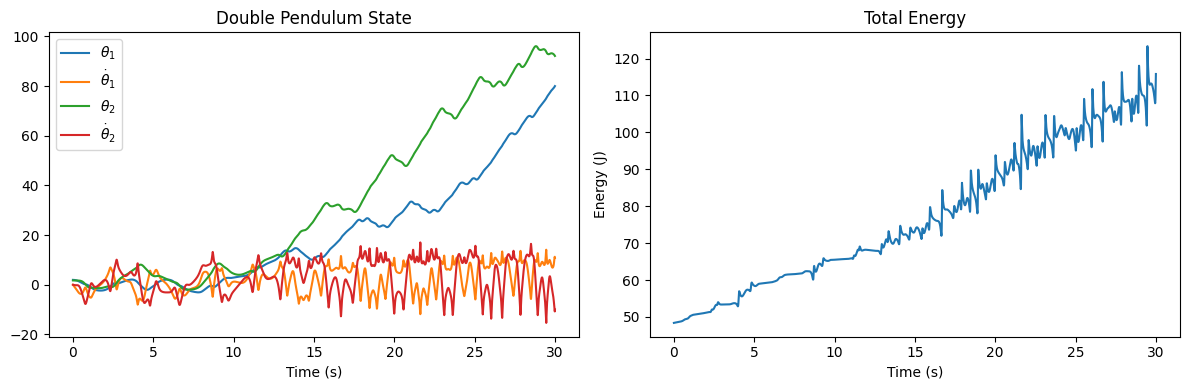

In [5]:
from numpy.linalg import norm
import matplotlib.pyplot as plt

# System parameters
params = {
    "m1": 1.0,
    "m2": 1.0,
    "L1": 1.0,
    "L2": 1.0,
    "g": 9.8
}

# Initial condition
x0 = np.array([np.pi / 1.6, 0.0, np.pi / 1.8, 0.0])

# Time settings
dt = 0.01
tf = 30.0
t_vec = np.arange(0, tf + dt, dt)
N = len(t_vec)

# Trajectory storage
X = [x0.copy()]
for k in range(1, N):
    x_next = forward_euler(params, double_pendulum_dynamics, X[-1], dt)
    X.append(x_next)

# Convert to numpy array
X = np.array(X)

# Compute energy
E = np.array([double_pendulum_energy(params, x) for x in X])

assert norm(X[-1]) > 1e-10, "State not updated"
assert 2 < (E[-1] / E[0]) < 3, "Energy should increase over time"

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t_vec, X[:, 0], label=r"$\theta_1$")
plt.plot(t_vec, X[:, 1], label=r"$\dot \theta_1$")
plt.plot(t_vec, X[:, 2], label=r"$\theta_2$")
plt.plot(t_vec, X[:, 3], label=r"$\dot \theta_2$")
plt.xlabel('Time (s)')
plt.title('Double Pendulum State')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t_vec, E)
plt.xlabel('Time (s)')
plt.ylabel('Energy (J)')
plt.title('Total Energy')

plt.tight_layout()
plt.show()


Now let's implement the next two integrators:

**Midpoint:**
$$ \begin{align} x_m &= x_k + \frac{\Delta t}{2} \cdot f(x_k) \\
              x_{k+1} &= x_k + \Delta t \cdot f({x}_m)\end{align}$$

**RK4:**
$$\begin{align}k_1 &= \Delta t \cdot f({x}_k) \\
k_2 &= \Delta t \cdot f(x_k + k_1/2)  \\
k_3 &= \Delta t \cdot f(x_k + k_2/2)  \\
k_4 &= \Delta t \cdot f(x_k + k_3)  \\
x_{k+1} &= x_k + (1/6)\cdot (k_1 + 2k_2 + 2k_3 + k_4)\end{align} $$

In [6]:
def midpoint(params, dynamics, x, dt):
    """
    Explicit Midpoint Method:
    x_m = x + (dt/2) * f(x)
    x_next = x + dt * f(x_m)
    """
    f_x = dynamics(params, x)
    x_m = x + 0.5 * dt * f_x
    f_xm = dynamics(params, x_m)
    x_next = x + dt * f_xm
    return x_next

def rk4(params, dynamics, x, dt):
    """
    Runge-Kutta 4th Order Integrator (RK4):
    x_{k+1} = x_k + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
    """
    k1 = dt * dynamics(params, x)
    k2 = dt * dynamics(params, x + 0.5 * k1)
    k3 = dt * dynamics(params, x + 0.5 * k2)
    k4 = dt * dynamics(params, x + k3)

    x_next = x + (1.0 / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return x_next

In [7]:
def simulate_explicit(params, dynamics, integrator, x0, dt, tf):
    """
    Simulates the system forward in time using an explicit integrator.

    Parameters:
        params:    system parameters (dict or tuple-like)
        dynamics:  function implementing the dynamics (e.g., double_pendulum_dynamics)
        integrator: integrator function (e.g., rk4, midpoint, forward_euler)
        x0:        initial state (numpy array)
        dt:        time step size
        tf:        final time

    Returns:
        X: list of states at each time step
        E: list of energy values at each time step
    """
    t_vec = np.arange(0, tf + dt, dt)
    N = len(t_vec)
    X = [np.zeros_like(x0) for _ in range(N)]
    X[0] = x0.copy()

    for k in range(N - 1):
        X[k + 1] = integrator(params, dynamics, X[k], dt)

    E = [double_pendulum_energy(params, x) for x in X]
    return X, E

x0 = np.array([np.pi/1.6, 0.0, np.pi/1.8, 0.0])

params = {
    'm1': 1.0,
    'm2': 1.0,
    'L1': 1.0,
    'L2': 1.0,
    'g': 9.8
}

### Part B (10 pts): Implicit Integrators

Explicit integrators work by calling a function with $x_k$ and $\Delta t$ as arguments, and returning $x_{k+1}$ like this:

$$x_{k+1} = f_{explicit}(x_k,\Delta t)$$

Implicit integrators on the other hand have the following relationship between the state at $x_k$ and $x_{k+1}$:

$$f_{implicit}(x_k, x_{k+1}, \Delta t) = 0$$

This means that if we want to get $x_{k+1}$ from $x_k$, we have to solve for a $x_{k+1}$ that satisfies the above equation. This is a rootfinding problem in $x_{k+1}$ (our unknown), so we juse have to use Newton's method.

Here are the three implicit integrators we are looking at, the first being Backward Euler (1st order):

$$f(x_k,x_{k+1},\Delta t) = x_k + \Delta t \cdot \dot{x}_{k+1} - x_{k+1} = 0 \quad \quad \text{Backward Euler}$$

Implicit Midpoint (2nd order)
$$ \begin{align} x_{k+1/2} &= \frac{1}{2}(x_k + x_{k+1})\\ f(x_k,x_{k+1},\Delta t) &= x_k + {\Delta t} \cdot \dot{x}_{k+1/2} - x_{k+1} = 0\quad \quad \text{Implicit Midpoint} \end{align} $$

Hermite Simpson (3rd order)
$$ \begin{align} x_{k+1/2} &= \frac{1}{2}(x_k + x_{k+1}) + \frac{\Delta t}{8}(\dot{x}_k - \dot{x}_{k+1})\\ f(x_k,x_{k+1},\Delta t) &= x_k + \frac{\Delta t}{6} \cdot (\dot{x}_k + 4\dot{x}_{k+1/2} + \dot{x}_{k+1}) - x_{k+1}= 0\quad \quad \text{Hermite-Simpson} \end{align} $$

When you implement these integrators, you will update the functions such that they take in a dynamics function, $x_k$ and $x_{k+1}$, and return the residuals described above. We are NOT solving these yet, we are simply returning the residuals for each implicit integrator that we want to be 0.
<!-- $$ f(x_k,x_{k+1},\Delta t) = x_k + \frac{\Delta t}{2} \cdot \dot{x}_{k+1/2} - x_{k+1} - x_{k+1}= 0 \quad \quad \text{Hermite-Simpson}$$ -->

In [8]:
def backward_euler(params, dynamics, x1, x2, dt):
    """
    Residual function for Backward Euler (1st order implicit)
    Residual: x1 + dt * f(x2) - x2 = 0
    """
    f_x2 = dynamics(params, x2)
    return x1 + dt * f_x2 - x2


def implicit_midpoint(params, dynamics, x1, x2, dt):
    """
    Residual function for Implicit Midpoint (2nd order implicit)
    Residual: x1 + dt * f( (x1 + x2)/2 ) - x2 = 0
    """
    x_mid = 0.5 * (x1 + x2)
    f_mid = dynamics(params, x_mid)
    return x1 + dt * f_mid - x2


def hermite_simpson(params, dynamics, x1, x2, dt):
    """
    Residual function for Hermite-Simpson (3rd order implicit)
    Residual: x1 + (dt/6) * (f(x1) + 4*f(x_half) + f(x2)) - x2 = 0
    Where:
        x_half = (x1 + x2)/2 + (dt/8)*(f(x1) - f(x2))
    """
    f1 = dynamics(params, x1)
    f2 = dynamics(params, x2)
    x_half = 0.5 * (x1 + x2) + (dt / 8) * (f1 - f2)
    f_half = dynamics(params, x_half)
    return x1 + (dt / 6) * (f1 + 4 * f_half + f2) - x2


In [9]:
def implicit_integrator_solve(params, dynamics, implicit_integrator, x1, dt, tol=1e-13, max_iters=10):
    """
    Solves for x2 using Newton's method such that:
        implicit_integrator(params, dynamics, x1, x2, dt) ≈ 0
    """
    x2 = x1.copy()  # initial guess

    for _ in range(max_iters):
        # Compute the residual
        r = implicit_integrator(params, dynamics, x1, x2, dt)

        # Check for convergence
        if np.linalg.norm(r) < tol:
            return x2

        # Finite difference Jacobian of residual w.r.t. x2
        n = len(x2)
        J = np.zeros((n, n))
        eps = 1e-6
        for j in range(n):
            dx = np.zeros(n)
            dx[j] = eps
            r_plus = implicit_integrator(params, dynamics, x1, x2 + dx, dt)
            r_minus = implicit_integrator(params, dynamics, x1, x2 - dx, dt)
            J[:, j] = (r_plus - r_minus) / (2 * eps)

        # Newton step: solve J dx = -r
        try:
            dx = np.linalg.solve(J, -r)
        except np.linalg.LinAlgError:
            raise RuntimeError("Jacobian is singular during Newton's method.")

        x2 += dx

    raise RuntimeError("implicit integrator solve failed to converge")

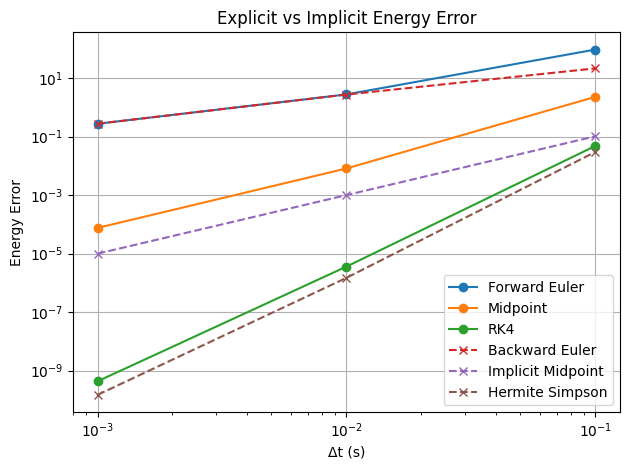

In [10]:
def simulate_implicit(params, dynamics, implicit_integrator, x0, dt, tf, tol=1e-13):
    t_vec = np.arange(0, tf + dt, dt)
    N = len(t_vec)
    X = [np.zeros_like(x0) for _ in range(N)]
    X[0] = x0.copy()

    for k in range(N - 1):
        X[k + 1] = implicit_integrator_solve(params, dynamics, implicit_integrator, X[k], dt, tol=tol)

    E = [double_pendulum_energy(params, x) for x in X]
    assert len(X) == N
    assert len(E) == N
    return X, E

def max_err_E(E):
    E0 = E[0]
    err = np.abs(np.array(E) - E0)
    return np.max(err)

def get_explicit_energy_error(integrator, dts):
    return [max_err_E(simulate_explicit(params, double_pendulum_dynamics, integrator, x0, dt, tf)[1]) for dt in dts]

def get_implicit_energy_error(integrator, dts):
    return [max_err_E(simulate_implicit(params, double_pendulum_dynamics, integrator, x0, dt, tf)[1]) for dt in dts]

# Constants
x0 = np.array([np.pi/1.6, 0, np.pi/1.8, 0])
params = {
    'm1': 1.0,
    'm2': 1.0,
    'L1': 1.0,
    'L2': 1.0,
    'g': 9.8
}
tf = 2.0

# Run simulation and plot
dts = [1e-3, 1e-2, 1e-1]

explicit_integrators = [forward_euler, midpoint, rk4]
implicit_integrators = [backward_euler, implicit_midpoint, hermite_simpson]

explicit_data = [get_explicit_energy_error(integrator, dts) for integrator in explicit_integrators]
implicit_data = [get_implicit_energy_error(integrator, dts) for integrator in implicit_integrators]

plt.figure()
for i, label in enumerate(["Forward Euler", "Midpoint", "RK4"]):
    plt.plot(dts, explicit_data[i], label=label, marker='o')

for i, label in enumerate(["Backward Euler", "Implicit Midpoint", "Hermite Simpson"]):
    plt.plot(dts, implicit_data[i], label=label, linestyle='--', marker='x')

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Δt (s)")
plt.ylabel("Energy Error")
plt.legend(loc="lower right")
plt.title("Explicit vs Implicit Energy Error")
plt.grid(True)
plt.tight_layout()
plt.show()


What we can see above is the maximum energy error for each of the integration methods. In general, the implicit methods of the same order are slightly better than the explicit ones.

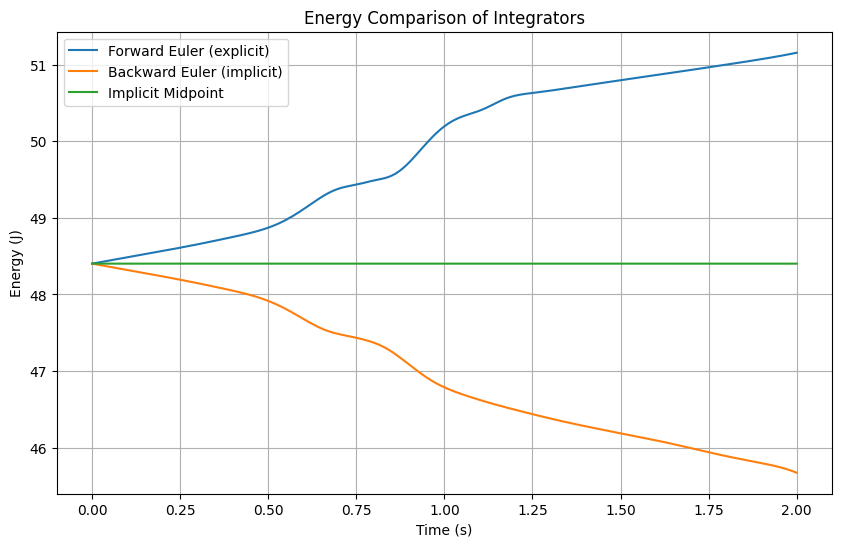

In [11]:
# Time parameters
dt = 0.01
tf = 2.0
t_vec = np.arange(0, tf + dt, dt)

# Simulate with all integrators
_, E1 = simulate_explicit(params, double_pendulum_dynamics, forward_euler, x0, dt, tf)
_, E2 = simulate_implicit(params, double_pendulum_dynamics, backward_euler, x0, dt, tf)
_, E3 = simulate_implicit(params, double_pendulum_dynamics, implicit_midpoint, x0, dt, tf)
_, E4 = simulate_implicit(params, double_pendulum_dynamics, hermite_simpson, x0, dt, tf)
_, E5 = simulate_explicit(params, double_pendulum_dynamics, midpoint, x0, dt, tf)
_, E6 = simulate_explicit(params, double_pendulum_dynamics, rk4, x0, dt, tf)

# Plot selected integrators
plt.figure(figsize=(10,6))
plt.plot(t_vec, E1, label="Forward Euler (explicit)")
plt.plot(t_vec, E2, label="Backward Euler (implicit)")
plt.plot(t_vec, E3, label="Implicit Midpoint")
plt.xlabel("Time (s)")
plt.ylabel("Energy (J)")
plt.legend()
plt.grid(True)
plt.title("Energy Comparison of Integrators")
plt.show()


In [12]:
# Test energy behavior
E0 = E1[0]

def assert_in_range(val, lower, upper, name):
    assert lower < val < upper, f"{name} not in range ({lower}, {upper}): got {val}"

def assert_close(val, ref, tol, name):
    assert abs(val - ref) < tol, f"{name} not within {tol} of {ref}: got {val}"

assert_in_range(E1[-1] - E0, 2.5, 3.0, "Forward Euler energy drift")
assert_in_range(E2[-1] - E0, -3.0, -2.5, "Backward Euler energy decay")
assert_close(E3[-1], E0, 1e-2, "Implicit Midpoint energy")
assert_close(E4[-1], E0, 1e-4, "Hermite Simpson energy")
assert_close(E5[-1], E0, 1e-1, "Midpoint energy")
assert_close(E6[-1], E0, 1e-4, "RK4 energy")

Another important takeaway from these integrators is that explicit Euler results in unstable behavior (as shown here by the growing energy), and implicit Euler results in artificial damping (losing energy). Implicit midpoint however maintains the correct energy. Even though the solution from implicit midpoint will vary from the initial energy, it does not move secularly one way or the other.

## Q2: Integration (25 pts)